In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm

In [102]:
# Load the Excel file
xls = pd.ExcelFile("Buildings_el.xlsx")
electricity_df = xls.parse('Electricity kWh')
weather_df = xls.parse('Weather archive')

# Clean electricity data
new_header = electricity_df.iloc[0]
electricity_df_clean = electricity_df[1:].copy()
electricity_df_clean.columns = new_header
electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)
electricity_df_clean["Timestamp"] = pd.to_datetime(electricity_df_clean["Timestamp"])
electricity_df_clean.set_index("Timestamp", inplace=True)
electricity_df_clean = electricity_df_clean.apply(pd.to_numeric, errors='coerce')
electricity_df_clean = electricity_df_clean.groupby(electricity_df_clean.index).mean()
electricity_df_clean["Total_kWh"] = electricity_df_clean.sum(axis=1)

# Clean weather data
weather_df.columns = weather_df.iloc[1]
weather_df_clean = weather_df[2:].copy()
weather_df_clean.rename(columns={"Local time in Tallinn ": "Timestamp"}, inplace=True)
weather_df_clean["Timestamp"] = pd.to_datetime(weather_df_clean["Timestamp"], dayfirst=True, errors='coerce')

# Rename relevant columns for clarity
weather_df_clean.rename(columns={
    "T": "Temperature (°C)",
    "P0": "Pressure (mmHg)",
    "U": "Humidity (%)",
    "Ff": "Wind speed (m/s)"
}, inplace=True)

# Define numeric columns
numeric_cols = ["Temperature (°C)", "Pressure (mmHg)", "Wind speed (m/s)"]

# Coerce non-numeric values to NaN
for col in numeric_cols:
    weather_df_clean[col] = pd.to_numeric(weather_df_clean[col], errors='coerce')

# Drop rows with invalid timestamps or all NaN numeric values
weather_df_clean.dropna(subset=["Timestamp"] + numeric_cols, how="all", inplace=True)

# Ensure only numeric columns are included for resampling
weather_df_clean = weather_df_clean[["Timestamp"] + numeric_cols]

# Set the timestamp as the index and resample to hourly frequency
weather_df_clean = weather_df_clean.set_index("Timestamp").resample("h").mean()
# Merge datasets
combined_df = electricity_df_clean.merge(weather_df_clean, left_index=True, right_index=True, how='inner')
print(combined_df.columns)
# Filter data for a specific building
building_id = "OBS"  # Replace with the desired building's identifier
building_data = combined_df[[building_id, "Total_kWh", "Temperature (°C)", "Pressure (mmHg)", "Wind speed (m/s)"]] # Adjust column name if needed

# Use the filtered data for further processing
data_2023 = building_data.loc['2023']  # Filter data for the year 2023
data_2023 = combined_df.loc['2023']

Index(['ICT', 'U06, U06A, U05B', 'OBS', 'U05, U04, U04B, GEO', 'TEG', 'LIB',
       'MEK', 'SOC', 'S01', 'D04', 'Total_kWh', 'Temperature (°C)',
       'Pressure (mmHg)', 'Wind speed (m/s)'],
      dtype='object')


C:\Users\tavim\AppData\Local\Temp\ipykernel_17076\1434856704.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)


In [103]:
# Prepare train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()
for month in range(1, 13):
    month_data = data_2023[data_2023.index.month == month]
    if len(month_data) < 4 * 7 * 24:
        continue
    start_idx = np.random.randint(0, len(month_data) - 2 * 7 * 24)
    train_weeks = month_data.iloc[start_idx:start_idx + 2 * 7 * 24]
    test_weeks = month_data.drop(train_weeks.index)
    train_data = pd.concat([train_data, train_weeks])
    test_data = pd.concat([test_data, test_weeks])
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)

# Normalize data
scaler = StandardScaler()
train_data["Total_kWh"] = scaler.fit_transform(train_data[["Total_kWh"]])
test_data["Total_kWh"] = scaler.transform(test_data[["Total_kWh"]])

# Create sequences
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i:i+seq_len].values)
        y.append(data[i+seq_len:i+seq_len+pred_len].values)
    return np.array(X), np.array(y)

seq_len = 168
pred_len = 24
X_train, y_train = create_sequences(train_data["Total_kWh"], seq_len, pred_len)
X_test, y_test = create_sequences(test_data["Total_kWh"], seq_len, pred_len)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [49]:
# Import TimesNet
import sys
sys.path.append(r"E:/Facultate/fewshot-ts-embedding/fewshot-ts-embedding")
from libs.timeserieslibrary.models.TimesNet import Model

# Define the TimesNet model
class Configs:
    task_name = 'long_term_forecast'  # Task type (e.g., 'long_term_forecast', 'short_term_forecast')
    seq_len = 168  # Input sequence length (e.g., 7 days of hourly data)
    label_len = 24  # Label length (context length for decoder, if applicable)
    pred_len = 24  # Prediction length (e.g., 1 day of hourly data)
    enc_in = 1  # Number of input features (e.g., electricity consumption)
    dec_in = 1  # Number of decoder input features
    c_out = 1  # Number of output features (e.g., electricity consumption)
    d_model = 64  # Model dimension
    e_layers = 2  # Number of encoder layers
    d_ff = 256  # Feedforward network dimension
    dropout = 0.1  # Dropout rate
    embed = "timeF"  # Embedding type (e.g., time features)
    freq = "h"  # Frequency of the data (e.g., hourly)
    top_k = 5  # Number of top periods for FFT
    num_kernels = 6  # Number of kernels for Inception blocks

configs = Configs()
model = Model(configs)
model = model.to(device)

In [104]:
# Train model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Filter data for the specific building (e.g., "MEK")
building_id = "OBS"  # Replace with the desired building's identifier
building_data = electricity_df_clean[building_id]

# Use the filtered data for further processing
train_data = train_data[[building_id]]
test_data = test_data[[building_id]]
# Define a function to create time-related features
def create_time_features(index):
    """
    Create time-related features based on the index (timestamps).
    """
    time_features = pd.DataFrame(index=index)
    time_features['hour'] = index.hour
    time_features['day'] = index.day
    time_features['weekday'] = index.weekday
    time_features['month'] = index.month
    return torch.tensor(time_features.values, dtype=torch.float32)

# Training loop with time features
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    # Wrap the DataLoader with tqdm for batch progress
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as t:
        for batch_X, batch_y in t:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Use the timestamps from the DataFrame index
            timestamps = train_data.index[:batch_X.size(1)]  # Adjust based on your DataLoader
            x_mark_enc = create_time_features(timestamps).to(device)
            
            # For the decoder, use future timestamps (e.g., prediction horizon)
            future_timestamps = train_data.index[batch_X.size(1):batch_X.size(1) + configs.pred_len]
            x_mark_dec = create_time_features(future_timestamps).to(device)

            optimizer.zero_grad()
            outputs = model(batch_X, x_mark_enc, None, x_mark_dec)  # Pass all required inputs
            
            # Add a singleton dimension to batch_y
            batch_y = batch_y.unsqueeze(-1)  # Ensure batch_y has shape [batch_size, pred_len, features]
            
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            # Update tqdm with the current loss
            t.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/20: 100%|██████████| 120/120 [01:29<00:00,  1.34batch/s, loss=0.0784]


Epoch 1/20, Loss: 0.0593


Epoch 2/20: 100%|██████████| 120/120 [01:29<00:00,  1.34batch/s, loss=0.0247]


Epoch 2/20, Loss: 0.0504


Epoch 3/20: 100%|██████████| 120/120 [01:29<00:00,  1.33batch/s, loss=0.0709]


Epoch 3/20, Loss: 0.0744


Epoch 4/20: 100%|██████████| 120/120 [01:30<00:00,  1.33batch/s, loss=0.027] 


Epoch 4/20, Loss: 0.0707


Epoch 5/20: 100%|██████████| 120/120 [01:30<00:00,  1.32batch/s, loss=0.0763]


Epoch 5/20, Loss: 0.0548


Epoch 6/20: 100%|██████████| 120/120 [01:31<00:00,  1.32batch/s, loss=0.0662]


Epoch 6/20, Loss: 0.0667


Epoch 7/20: 100%|██████████| 120/120 [01:31<00:00,  1.32batch/s, loss=0.126] 


Epoch 7/20, Loss: 0.0473


Epoch 8/20: 100%|██████████| 120/120 [01:31<00:00,  1.32batch/s, loss=0.0675]


Epoch 8/20, Loss: 0.0483


Epoch 9/20: 100%|██████████| 120/120 [01:31<00:00,  1.32batch/s, loss=0.0157]


Epoch 9/20, Loss: 0.0359


Epoch 10/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.0573]


Epoch 10/20, Loss: 0.0615


Epoch 11/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.124] 


Epoch 11/20, Loss: 0.0513


Epoch 12/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.0259]


Epoch 12/20, Loss: 0.0443


Epoch 13/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.0231]


Epoch 13/20, Loss: 0.0390


Epoch 14/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.0421]


Epoch 14/20, Loss: 0.0402


Epoch 15/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.0203]


Epoch 15/20, Loss: 0.0446


Epoch 16/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.0414]


Epoch 16/20, Loss: 0.0566


Epoch 17/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.0466]


Epoch 17/20, Loss: 0.0628


Epoch 18/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.0441]


Epoch 18/20, Loss: 0.0583


Epoch 19/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.0422]


Epoch 19/20, Loss: 0.0516


Epoch 20/20: 100%|██████████| 120/120 [01:31<00:00,  1.31batch/s, loss=0.0339]

Epoch 20/20, Loss: 0.0514


In [105]:
# Evaluate model for a single building
model.eval()
test_dataset = torch.utils.data.TensorDataset(X_test.unsqueeze(-1), y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

actuals, predictions = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Generate time-related features for the encoder and decoder
        timestamps = test_data.index[:batch_X.size(1)]  # Adjust based on your DataLoader
        x_mark_enc = create_time_features(timestamps).to(device)
        future_timestamps = test_data.index[batch_X.size(1):batch_X.size(1) + configs.pred_len]
        x_mark_dec = create_time_features(future_timestamps).to(device)
        
        # Generate predictions
        outputs = model(batch_X, x_mark_enc, None, x_mark_dec)
        
        # Add predictions and actuals to the lists
        actuals.append(batch_y.cpu().numpy())
        predictions.append(outputs.cpu().numpy())

# Concatenate all batches
actuals = np.concatenate(actuals, axis=0)
predictions = np.concatenate(predictions, axis=0)

# Reshape to 2D or 1D if necessary
actuals = actuals.squeeze()  # Remove singleton dimensions
predictions = predictions.squeeze()  # Remove singleton dimensions

# Calculate Mean Absolute Percentage Error (MAPE) for the specific building
mape = mean_absolute_percentage_error(actuals, predictions)
print(f"Test MAPE for building 'MEK': {mape:.2f}%")

Test MAPE for building 'MEK': 1.13%


Test MAPE for building 'OBS': 0.07%


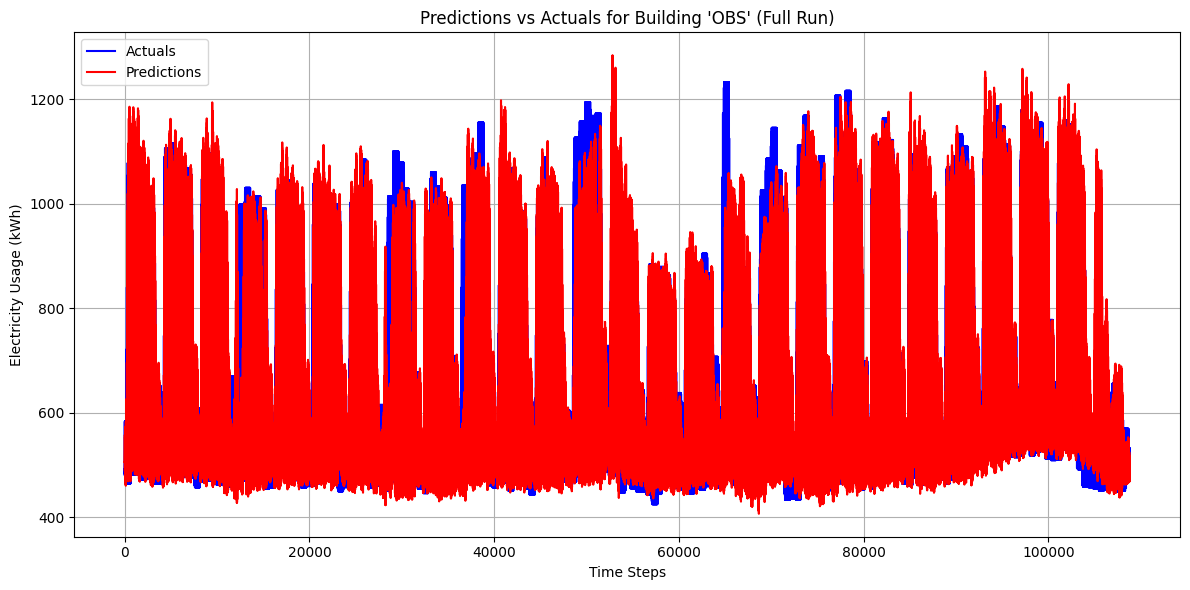

In [106]:
# Unscale the predictions and actuals
actuals_unscaled = scaler.inverse_transform(actuals.reshape(-1, 1)).squeeze()
predictions_unscaled = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze()

# Calculate MAPE on unscaled data
mape = mean_absolute_percentage_error(actuals_unscaled, predictions_unscaled)
print(f"Test MAPE for building '{building_id}': {mape:.2f}%")

# Plot the entire run of predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actuals_unscaled, label="Actuals", color="blue")
plt.plot(predictions_unscaled, label="Predictions", color="red")
plt.title(f"Predictions vs Actuals for Building '{building_id}' (Full Run)")
plt.xlabel("Time Steps")
plt.ylabel("Electricity Usage (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\tavim\AppData\Local\Temp\ipykernel_17076\215836489.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)


Training Months: [7, 9]
Testing Months: [1, 2, 3, 4, 5, 6, 8, 10, 11, 12]
Training Data Shape: torch.Size([1272, 168]), torch.Size([1272, 24])
Testing Data Shape: torch.Size([7102, 168]), torch.Size([7102, 24])


Epoch 1/20: 100%|██████████| 38/38 [00:28<00:00,  1.31batch/s, loss=0.246]


Epoch 1/20, Loss: 0.5913


Epoch 2/20: 100%|██████████| 38/38 [00:28<00:00,  1.33batch/s, loss=0.0944]


Epoch 2/20, Loss: 0.1447


Epoch 3/20: 100%|██████████| 38/38 [00:28<00:00,  1.33batch/s, loss=0.104] 


Epoch 3/20, Loss: 0.1103


Epoch 4/20: 100%|██████████| 38/38 [00:28<00:00,  1.31batch/s, loss=0.0804]


Epoch 4/20, Loss: 0.0975


Epoch 5/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.1]   


Epoch 5/20, Loss: 0.0892


Epoch 6/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.0903]


Epoch 6/20, Loss: 0.0783


Epoch 7/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.0966]


Epoch 7/20, Loss: 0.0669


Epoch 8/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.108] 


Epoch 8/20, Loss: 0.0630


Epoch 9/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.0709]


Epoch 9/20, Loss: 0.0542


Epoch 10/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.0527]


Epoch 10/20, Loss: 0.0508


Epoch 11/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.0387]


Epoch 11/20, Loss: 0.0472


Epoch 12/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.0465]


Epoch 12/20, Loss: 0.0494


Epoch 13/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.019] 


Epoch 13/20, Loss: 0.0435


Epoch 14/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.0902]


Epoch 14/20, Loss: 0.0447


Epoch 15/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.028] 


Epoch 15/20, Loss: 0.0442


Epoch 16/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.0257]


Epoch 16/20, Loss: 0.0379


Epoch 17/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.0312]


Epoch 17/20, Loss: 0.0375


Epoch 18/20: 100%|██████████| 38/38 [00:28<00:00,  1.32batch/s, loss=0.0321]


Epoch 18/20, Loss: 0.0394


Epoch 19/20: 100%|██████████| 38/38 [00:29<00:00,  1.31batch/s, loss=0.02]  


Epoch 19/20, Loss: 0.0378


Epoch 20/20: 100%|██████████| 38/38 [00:28<00:00,  1.31batch/s, loss=0.0272]


Epoch 20/20, Loss: 0.0369
Test MAPE for building 'OBS': 0.06%


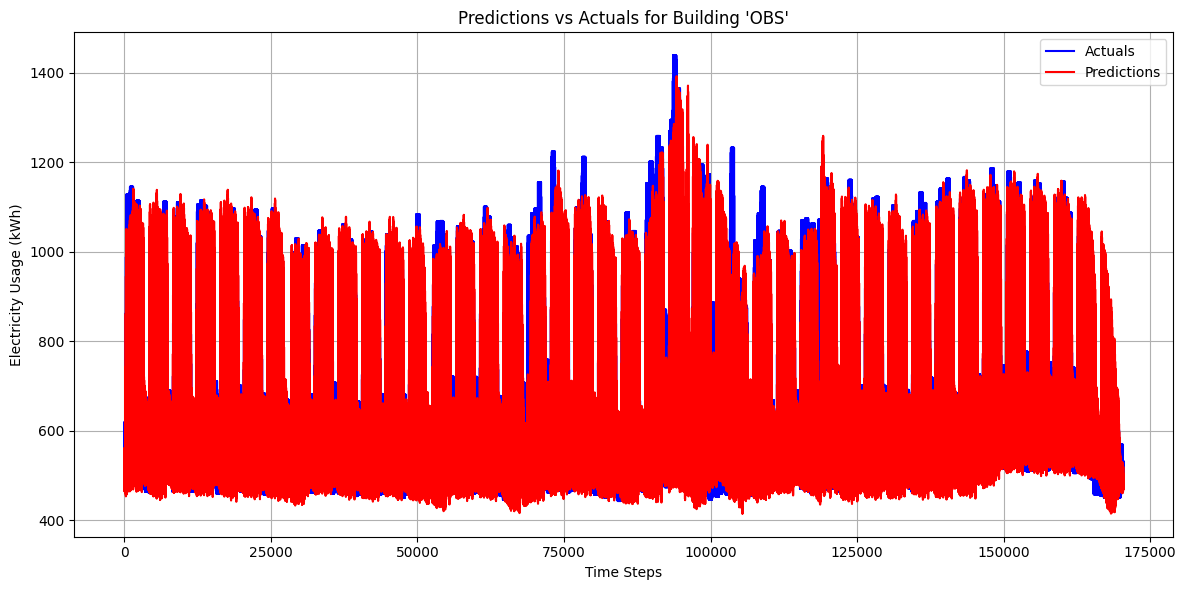

In [110]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Load the Excel file
xls = pd.ExcelFile("Buildings_el.xlsx")
electricity_df = xls.parse('Electricity kWh')
weather_df = xls.parse('Weather archive')

# Clean electricity data
new_header = electricity_df.iloc[0]
electricity_df_clean = electricity_df[1:].copy()
electricity_df_clean.columns = new_header
electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)
electricity_df_clean["Timestamp"] = pd.to_datetime(electricity_df_clean["Timestamp"])
electricity_df_clean.set_index("Timestamp", inplace=True)
electricity_df_clean = electricity_df_clean.apply(pd.to_numeric, errors='coerce')
electricity_df_clean = electricity_df_clean.groupby(electricity_df_clean.index).mean()
electricity_df_clean["Total_kWh"] = electricity_df_clean.sum(axis=1)

# Clean weather data
weather_df.columns = weather_df.iloc[1]
weather_df_clean = weather_df[2:].copy()
weather_df_clean.rename(columns={"Local time in Tallinn ": "Timestamp"}, inplace=True)
weather_df_clean["Timestamp"] = pd.to_datetime(weather_df_clean["Timestamp"], dayfirst=True, errors='coerce')

# Rename relevant columns for clarity
weather_df_clean.rename(columns={
    "T": "Temperature (°C)",
    "P0": "Pressure (mmHg)",
    "U": "Humidity (%)",
    "Ff": "Wind speed (m/s)"
}, inplace=True)

# Define numeric columns
numeric_cols = ["Temperature (°C)", "Pressure (mmHg)", "Wind speed (m/s)"]

# Coerce non-numeric values to NaN
for col in numeric_cols:
    weather_df_clean[col] = pd.to_numeric(weather_df_clean[col], errors='coerce')

# Drop rows with invalid timestamps or all NaN numeric values
weather_df_clean.dropna(subset=["Timestamp"] + numeric_cols, how="all", inplace=True)

# Ensure only numeric columns are included for resampling
weather_df_clean = weather_df_clean[["Timestamp"] + numeric_cols]

# Set the timestamp as the index and resample to hourly frequency
weather_df_clean = weather_df_clean.set_index("Timestamp").resample("h").mean()

# Merge datasets
combined_df = electricity_df_clean.merge(weather_df_clean, left_index=True, right_index=True, how='inner')

# Filter data for a specific building
building_id = "OBS"  # Replace with the desired building's identifier
building_data = combined_df[[building_id, "Total_kWh", "Temperature (°C)", "Pressure (mmHg)", "Wind speed (m/s)"]]

# Use the filtered data for further processing
data_2023 = building_data.loc['2023']  # Filter data for the year 2023

# Randomly select 2 months for training
all_months = list(range(1, 13))
train_months = random.sample(all_months, 2)
test_months = [month for month in all_months if month not in train_months]

print(f"Training Months: {train_months}")
print(f"Testing Months: {test_months}")

# Prepare train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Add data for the selected training months
for month in train_months:
    month_data = data_2023[data_2023.index.month == month]
    train_data = pd.concat([train_data, month_data])

# Add data for the remaining testing months
for month in test_months:
    month_data = data_2023[data_2023.index.month == month]
    test_data = pd.concat([test_data, month_data])

# Sort the data by index
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)

# Normalize data
scaler = StandardScaler()
train_data["Total_kWh"] = scaler.fit_transform(train_data[["Total_kWh"]])
test_data["Total_kWh"] = scaler.transform(test_data[["Total_kWh"]])

# Create sequences
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i:i+seq_len].values)
        y.append(data[i+seq_len:i+seq_len+pred_len].values)
    return np.array(X), np.array(y)

seq_len = 168
pred_len = 24
X_train, y_train = create_sequences(train_data["Total_kWh"], seq_len, pred_len)
X_test, y_test = create_sequences(test_data["Total_kWh"], seq_len, pred_len)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, {y_test.shape}")

# Import TimesNet
import sys
sys.path.append(r"E:/Facultate/fewshot-ts-embedding/fewshot-ts-embedding")
from libs.timeserieslibrary.models.TimesNet import Model

# Define the TimesNet model
class Configs:
    task_name = 'long_term_forecast'
    seq_len = 168
    label_len = 24
    pred_len = 24
    enc_in = 1
    dec_in = 1
    c_out = 1
    d_model = 64
    e_layers = 2
    d_ff = 256
    dropout = 0.1
    embed = "timeF"
    freq = "h"
    top_k = 5
    num_kernels = 6

configs = Configs()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model(configs).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def create_time_features(index):
    """
    Create time-related features based on the index (timestamps).
    """
    time_features = pd.DataFrame(index=index)
    time_features['hour'] = index.hour
    time_features['day'] = index.day
    time_features['weekday'] = index.weekday
    time_features['month'] = index.month
    return torch.tensor(time_features.values, dtype=torch.float32)

# Training loop with time features
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    # Wrap the DataLoader with tqdm for batch progress
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as t:
        for batch_X, batch_y in t:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Add a singleton dimension for the feature axis
            batch_X = batch_X.unsqueeze(-1)  # Shape: [batch_size, seq_len, 1]
            
            # Generate time-related features for the encoder and decoder
            timestamps = train_data.index[:batch_X.size(1)]  # Adjust based on your DataLoader
            x_mark_enc = create_time_features(timestamps).to(device)
            future_timestamps = train_data.index[batch_X.size(1):batch_X.size(1) + configs.pred_len]
            x_mark_dec = create_time_features(future_timestamps).to(device)

            optimizer.zero_grad()
            outputs = model(batch_X, x_mark_enc, None, x_mark_dec)  # Pass all required inputs
            
            # Add a singleton dimension to batch_y
            batch_y = batch_y.unsqueeze(-1)  # Ensure batch_y has shape [batch_size, pred_len, features]
            
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            # Update tqdm with the current loss
            t.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluate model
model.eval()
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

actuals, predictions = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Add a singleton dimension for the feature axis
        batch_X = batch_X.unsqueeze(-1)  # Shape: [batch_size, seq_len, 1]
        
        # Generate time-related features for the encoder and decoder
        timestamps = test_data.index[:batch_X.size(1)]  # Adjust based on your DataLoader
        x_mark_enc = create_time_features(timestamps).to(device)
        future_timestamps = test_data.index[batch_X.size(1):batch_X.size(1) + configs.pred_len]
        x_mark_dec = create_time_features(future_timestamps).to(device)
        
        # Generate predictions
        outputs = model(batch_X, x_mark_enc, None, x_mark_dec)
        
        # Add predictions and actuals to the lists
        actuals.append(batch_y.cpu().numpy())
        predictions.append(outputs.cpu().numpy())

# Concatenate all batches
actuals = np.concatenate(actuals, axis=0)
predictions = np.concatenate(predictions, axis=0)

# Unscale the predictions and actuals
actuals_unscaled = scaler.inverse_transform(actuals.reshape(-1, 1)).squeeze()
predictions_unscaled = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze()

# Calculate MAPE
mape = mean_absolute_percentage_error(actuals_unscaled, predictions_unscaled)
print(f"Test MAPE for building '{building_id}': {mape:.2f}%")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actuals_unscaled, label="Actuals", color="blue")
plt.plot(predictions_unscaled, label="Predictions", color="red")
plt.title(f"Predictions vs Actuals for Building '{building_id}'")
plt.xlabel("Time Steps")
plt.ylabel("Electricity Usage (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()